# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [27]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.model_selection as model_selection
import seaborn as sns
import time

In [33]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [42]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Acknowledgements**

https://github.com/CSSEGISandData/COVID-19

### Preparar Datos

In [4]:
# recoleccion de datos
url1 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv?raw=true'
confirmed_global = pd.read_csv(url1)
confirmed_global['Case'] = pd.Series('confirmed' for x in range(len(confirmed_global.index)))

url2 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv?raw=true'
confirmed_us = pd.read_csv(url2)
confirmed_us['Case'] = pd.Series('confirmed' for x in range(len(confirmed_us.index)))

url3 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv?raw=true'
deaths_us = pd.read_csv(url3)
deaths_us['Case'] = pd.Series('deaths' for x in range(len(deaths_us.index)))

url4 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv?raw=true'
deaths_global = pd.read_csv(url4)
deaths_global['Case'] = pd.Series('deaths' for x in range(len(deaths_global.index)))

url5 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv?raw=true'
recovered_global = pd.read_csv(url5)
recovered_global['Case'] = pd.Series('recovered' for x in range(len(recovered_global.index)))

In [5]:
# Remover columnas no comunes
confirmed_us = confirmed_us.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'], axis = 1)
deaths_us = deaths_us.drop(columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Population'], axis = 1)

#data frame global
frames_global = [confirmed_global, deaths_global, recovered_global]
df_global = pd.concat(frames_global)
df_global = df_global.rename(columns = {"Province/State" : "Province_State", "Country/Region" : "Country_Region"})

#data frame US
frames_us = [confirmed_us, deaths_us]
df_us = pd.concat(frames_us)
df_us = df_us.rename(columns = {'Long_':'Long'})

#data frame mundial
covid_frames = [df_global, df_us]
df_covid = pd.concat(covid_frames)

In [6]:
df_covid

,Province_State,Country_Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,Case
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,66903,67743,68366,69130,70111,70761,71838,72977,74026,confirmed
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,132229,132244,132264,132285,132297,132309,132315,132337,132351,confirmed
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,127361,127646,127926,128198,128456,128725,128913,129218,129640,confirmed
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,13664,13671,13682,13693,13693,13693,13727,13729,13744,confirmed
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,32933,33338,33607,33944,34180,34366,34551,34752,34960,confirmed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,Wyoming,US,43.935225,-110.589080,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,deaths
3338,Wyoming,US,41.287818,-110.547578,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,deaths
3339,Wyoming,US,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,deaths
3340,Wyoming,US,43.904516,-107.680187,0,0,0,0,0,0,...,26,26,26,26,26,26,26,26,26,deaths


In [7]:
# Pivot y transformación de los datos
melt_table = df_covid.melt(id_vars = ['Province_State', 'Country_Region','Lat','Long','Case'], var_name = 'Date',value_name = 'Cases')
pivot_table = melt_table.pivot(index = None, columns = 'Case', values = 'Cases')
covid_data = melt_table.join(pivot_table,lsuffix = '_prueba', rsuffix ='_table' )
covid_data = covid_data.drop(columns = ['Case','Cases'], axis = 1)
covid_data = covid_data.rename(columns = {'Province_State':'Province/State','Country_Region':'Country/Region','confirmed':'Confirmed','deaths':'Deaths','recovered':'Recovered'})
valores = {'Confirmed':0,'Deaths':0,'Recovered':0}
covid_data = covid_data.fillna(value = valores)
covid_data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0.0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,1/22/20,0.0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0.0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0.0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3733501,Wyoming,US,43.935225,-110.589080,6/2/21,0.0,9.0,0.0
3733502,Wyoming,US,41.287818,-110.547578,6/2/21,0.0,13.0,0.0
3733503,Wyoming,US,0.000000,0.000000,6/2/21,0.0,1.0,0.0
3733504,Wyoming,US,43.904516,-107.680187,6/2/21,0.0,26.0,0.0


In [8]:
#Convertir Date a formato de fecha
covid_data['Date'] = pd.to_datetime(covid_data['Date'], format = '%d%m%y', infer_datetime_format=True)
covid_data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0.0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0.0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0.0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0.0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3733501,Wyoming,US,43.935225,-110.589080,2021-06-02,0.0,9.0,0.0
3733502,Wyoming,US,41.287818,-110.547578,2021-06-02,0.0,13.0,0.0
3733503,Wyoming,US,0.000000,0.000000,2021-06-02,0.0,1.0,0.0
3733504,Wyoming,US,43.904516,-107.680187,2021-06-02,0.0,26.0,0.0


### Definición del training set

In [9]:
# filtrar fechas en training_set
start_date = '2020-01-22'
end_date = '2020-05-10'

after_start = covid_data['Date'] >= start_date
before_end = covid_data['Date'] <= end_date
between = after_start & before_end
train = covid_data.loc[between]
train

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0.0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0.0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0.0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0.0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
824665,Wyoming,US,43.935225,-110.589080,2020-05-10,0.0,0.0,0.0
824666,Wyoming,US,41.287818,-110.547578,2020-05-10,0.0,0.0,0.0
824667,Wyoming,US,0.000000,0.000000,2020-05-10,0.0,6.0,0.0
824668,Wyoming,US,43.904516,-107.680187,2020-05-10,0.0,0.0,0.0


In [10]:
# seleccionar Guatemala y confirmados > 0
train_gt = train[(train['Country/Region'] == 'Guatemala') & (train['Confirmed']>0)]
train_gt

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
389982,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1.0,0.0,0.0
397479,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1.0,0.0,0.0
404976,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2.0,0.0,0.0
412473,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6.0,0.0,0.0
419970,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6.0,0.0,0.0
427467,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9.0,0.0,0.0
434964,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12.0,0.0,0.0
442461,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17.0,0.0,0.0
449958,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19.0,0.0,0.0
457455,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20.0,0.0,0.0


#### Añadir campo Day_Number

In [11]:
train_gt = train_gt.sort_values(by = 'Date')

In [12]:
# Crear un data frame de fechas con el número de día a partir de la primera fecha
dates = train_gt.groupby(['Date']).sum().drop(columns = ['Lat','Long','Confirmed','Deaths','Recovered'])
dates['Day_Number'] = np.arange(len(dates))
dates

,Day_Number
Date,
2020-03-14,0
2020-03-15,1
2020-03-16,2
2020-03-17,3
2020-03-18,4
2020-03-19,5
2020-03-20,6
2020-03-21,7
2020-03-22,8


In [13]:
# Añadir columna de número de día
train_gt = pd.merge(train_gt, dates, on = ['Date','Date'])
train_gt

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Day_Number
0,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1.0,0.0,0.0,0
1,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1.0,0.0,0.0,1
2,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2.0,0.0,0.0,2
3,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6.0,0.0,0.0,3
4,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6.0,0.0,0.0,4
5,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9.0,0.0,0.0,5
6,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12.0,0.0,0.0,6
7,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17.0,0.0,0.0,7
8,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19.0,0.0,0.0,8
9,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20.0,0.0,0.0,9


### Exploración de los datos

<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

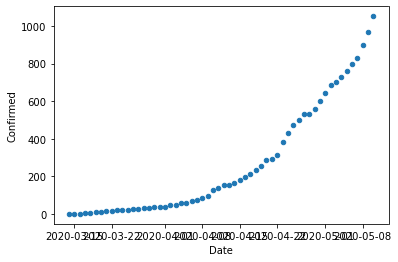

In [14]:
train_gt.plot.scatter(x = 'Date', y = 'Confirmed')

#### Transformar variable 'Confirmed'

<AxesSubplot:xlabel='Date', ylabel='ln(Confirmed)'>

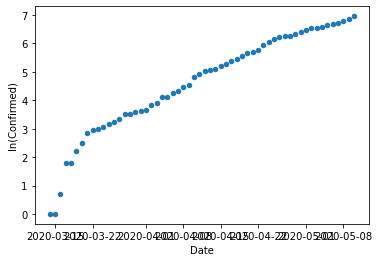

In [15]:
# Variable 'Confirmed' transformada por medio de logaritmo
train_gt["ln(Confirmed)"] = np.log(train_gt['Confirmed'])
train_gt.plot.scatter(x = 'Date', y = 'ln(Confirmed)')

In [26]:
train_gt

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Day_Number,ln(Confirmed)
0,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1.0,0.0,0.0,0,0.000000
1,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1.0,0.0,0.0,1,0.000000
2,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2.0,0.0,0.0,2,0.693147
3,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6.0,0.0,0.0,3,1.791759
4,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6.0,0.0,0.0,4,1.791759
5,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9.0,0.0,0.0,5,2.197225
6,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12.0,0.0,0.0,6,2.484907
7,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17.0,0.0,0.0,7,2.833213
8,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19.0,0.0,0.0,8,2.944439
9,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20.0,0.0,0.0,9,2.995732


In [31]:
# Definición de variable independiente y dependiente de entrenamiento
x_data = np.array(train_gt['Day_Number']).reshape(-1,1)
y_data = np.array(train_gt['ln(Confirmed)']).reshape(-1,1)

### Definición del modelo

#### Creación del grafo

In [35]:
tf.reset_default_graph()
gr = tf.Graph()
with gr.as_default():
    tensor_x = tf.placeholder(tf.float32,[None,1],"tensor_x")
    tensor_y = tf.placeholder(tf.float32,[None,1],"tensor_y")
    weight = tf.get_variable("peso",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
    learning_rate = tf.placeholder("float", name = "learning_rate")
    bias = tf.get_variable("sesgo",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
    epochs = tf.placeholder(tf.int32, name = "epochs")
    batch_size = tf.placeholder(tf.int32, name = "batch_size")
    with tf.name_scope("modelo"):
        y_hat = tf.add(tf.multiply(tensor_x,weight),bias)
    with tf.name_scope("MSE"):
        costo = 1/2*tf.reduce_mean(tf.math.square(y_hat - tensor_y))
        costo_summary = tf.summary.scalar("MSE", costo)
    with tf.name_scope("gradiente"):
        gradiente = tf.gradients(costo, [weight, bias])
    with tf.name_scope("actualizacion_parametros"):
        actualizacion_weight = tf.assign(weight, weight - learning_rate*gradiente[0])
        actualizacion_bias = tf.assign(bias, bias - learning_rate*gradiente[1])
        actualizacion_parametros = tf.group(actualizacion_weight,actualizacion_bias)
    init = tf.global_variables_initializer()

#### Función de entrenamiento

In [48]:
def entrenar_modelo(x_data, y_data, lr, epoch, b_size):
    total_iteraciones = int(len(x_data)/b_size)
    tf.reset_default_graph()
    
    with tf.Session(graph = gr) as sess:
        timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
        writer = tf.summary.FileWriter('./TB_log_dir/'+str(timestamp)+'_lr='+str(lr)+'_b_size='+str(b_size)+'_epoch='+str(epoch),gr)
        sess.run(init)

        for e in range(epoch):

            for i in range(total_iteraciones):
                muestra_inicio = i*b_size
                muestra_fin = muestra_inicio + b_size
                x_mb =  np.array(x_data[muestra_inicio:muestra_fin]).reshape([-1,1])
                y_mb = np.array(y_data[muestra_inicio:muestra_fin]).reshape([-1,1])

                feed_dict2 = {tensor_x :x_data , tensor_y:y_data, learning_rate:lr, epochs:epoch, batch_size:b_size}
                act_p, w, b, c = sess.run([actualizacion_parametros, weight, bias, costo_summary], feed_dict=feed_dict2)
                #print("Epoch {} iteracion {} m={} b={}".format(e,i,w,b))
                writer.add_summary(c, e)

            feed_dict = {tensor_x:np.array(x_data).reshape(-1,1), tensor_y:np.array(y_data).reshape(-1,1)}
            prediccion = sess.run(y_hat, feed_dict = feed_dict)

        final_weight,final_bias = sess.run([weight,bias],feed_dict=feed_dict)
        print("Weight {} | Bias {}".format(final_weight, final_bias))

        writer.close()
        
        return final_weight, final_bias

In [104]:
entrenar_modelo(x_data, y_data, 0.0001, 1000, 32)

Weight 0.14504754543304443 | Bias 0.04735024645924568


(0.14504755, 0.047350246)

In [103]:
%tensorboard --logdir "C:\Users\eddso\OneDrive\Maestría\Tareas Git Hub\tareas_data_science\TB_log_dir"dd

Reusing TensorBoard on port 6006 (pid 5720), started 4 days, 5:31:44 ago. (Use '!kill 5720' to kill it.)

<img src="https://github.com/eddson90/tareas_data_science/blob/main/graph_tensorboard_tarea1_sl1.PNG?raw=true">

In [148]:
resultado = entrenar_modelo(x_data, y_data, 0.001, 10000, 8)

Weight 0.10130542516708374 | Bias 1.7237370014190674


In [106]:
#Si se desea predecir el 30 de mayo de 2020 o cualquier día pára los casos confirmados de Guatemala, se puede crear
# una función que indique el numero de día según la fecha
def numero_dia(d):
    pivote = datetime.strptime('2020-03-14', "%Y-%m-%d")
    d = datetime.strptime(d, "%Y-%m-%d")
    return abs((pivote - d).days)

In [107]:
numero_dia('2020-05-30')

77

In [114]:
"""Se crea una funcion que prediga los casos confirmados, transformando el valor predecido por medio de la función
exponencial
"""
def prediccion(fecha):
    x = numero_dia(fecha)
    return np.exp(resultado[0]*x+resultado[1])

In [149]:
# Predicción para el 30 de mayo
prediccion('2020-05-30')

13687.725198535014